[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/mhuertascompany/euclid-school-2025/blob/main/Y2/notebooks/sbi_LtU_MHo.ipynb)

# Simulation Based Inference for cosmology

Tutorial largely based on the notebooks and examples available at https://github.com/maho3/ltu-ili developped by Matt Ho et al. in the fraework of the LtU collaboration - Please refer to the repository for more info. We thank the LtU collaboration for making this material available



In [25]:

# --- COLAB BOOTSTRAP (safe on local; no-op unless in Colab) -----------------
import os, sys, subprocess, importlib
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
from pathlib import Path

IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    pass

REPO_URL  = "https://github.com/mhuertascompany/euclid-school-2025.git"
REPO_DIR  = Path("/content/euclid-school-2025")
NOTE_PATH = REPO_DIR / "notebooks" / "Y2"   # <- THIS notebook lives here

def _pip(*args):
    cmd = [sys.executable, "-m", "pip", "install", "-q", "--upgrade"] + list(args)
    print("pip:", " ".join(args)); subprocess.run(cmd, check=True)

if IN_COLAB:
    print("Running on Colab ✓")
    # Clone repo if needed and cd into Y2
    if not REPO_DIR.exists():
        subprocess.run(["git", "clone", "-q", REPO_URL, str(REPO_DIR)], check=True)
    os.chdir(NOTE_PATH)
    print("Working dir:", Path.cwd())

    # Minimal, targeted deps (avoid reinstalling torch/torchvision from pip)
    _pip("pip", "setuptools", "wheel")
    # Fix NumPy/h5py ABI upfront (prevents 'numpy.dtype size changed' crashes)
    _pip("h5py>=3.11")
    # SBI/ILI ecosystem
    _pip("sbi", "lampe==0.9.0", "zuko", "einops", "tqdm", "seaborn", "pyarrow", "pandas", "matplotlib")
    # ILI itself (no editable mode on Colab)
    _pip("git+https://github.com/maho3/ltu-ili.git")

# Sanity print (torch is preinstalled on Colab)
import torch, numpy
print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print("NumPy:", numpy.__version__)
try:
    import h5py; print("h5py :", h5py.__version__)
except Exception as e:
    print("h5py import error:", e)
# -----------------------------------------------------------------------------


Python: 3.10.15
Torch: 2.5.1 | CUDA available: False
NumPy: 2.0.2
h5py : 3.14.0



## Paths, Device & Seeds

Unify working directory and file locations across local and Colab.  
Creates a `data/` folder next to this notebook and sets the device and random seeds.


In [2]:

# --- PATHS, DEVICE, SEEDS ----------------------------------------------------
from pathlib import Path
import torch, random, os, numpy as np

# Ensure we are inside notebooks/Y2 when possible
REPO_ROOT = Path.cwd()
if REPO_ROOT.name != "Y2":
    for up in [Path.cwd()] + [Path.cwd().parents[i] for i in range(len(Path.cwd().parents))]:
        maybe = up / "notebooks" / "Y2"
        if maybe.exists():
            os.chdir(maybe); REPO_ROOT = maybe; break

DATA_DIR  = REPO_ROOT / "data"     # <— datasets live here
DATA_DIR.mkdir(exist_ok=True, parents=True)
print("Notebook dir:", REPO_ROOT)
print("Data dir    :", DATA_DIR)

# Device logic (Colab: prefer CUDA; local Mac uses CPU/MPS as available)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

def set_seed(seed=1234):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(1234)
print("Device:", DEVICE)
# -----------------------------------------------------------------------------


Notebook dir: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks
Data dir    : /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks/data
Device: cpu



## Download Helpers

Lightweight, idempotent functions for downloading from **HTTP** or **Google Drive**, and automatically extracting archives (zip/tar).  
Use them anywhere data is fetched in the notebook.


In [3]:

# --- DOWNLOAD HELPERS --------------------------------------------------------
import re, zipfile, tarfile, urllib.request
from pathlib import Path

def _is_gdrive_url(url: str) -> bool:
    return "drive.google.com" in url or re.search(r"^https?://drive\.google\.com", url) is not None

def _gdrive_id(url_or_id: str) -> str:
    # Accept a raw file id or any common Drive sharing URL
    if re.fullmatch(r"[A-Za-z0-9_\-]{20,}", url_or_id):
        return url_or_id
    m = re.search(r"/d/([A-Za-z0-9_-]{20,})", url_or_id)
    if m: return m.group(1)
    m = re.search(r"id=([A-Za-z0-9_-]{20,})", url_or_id)
    if m: return m.group(1)
    raise ValueError(f"Cannot parse Google Drive id from: {url_or_id}")

def _pip(*args):
    import sys, subprocess
    cmd = [sys.executable, "-m", "pip", "install", "-q", "--upgrade"] + list(args)
    subprocess.run(cmd, check=True)

def download(url_or_id: str, dst: Path, unzip: bool=True) -> Path:
    """
    Download to `dst`. If dst is a directory, we infer filename from URL/id.
    Unzips/untars into its folder by default. Returns final path (file or extracted dir).
    """
    dst = Path(dst)
    dst.parent.mkdir(parents=True, exist_ok=True)

    # Determine file path
    if dst.is_dir() or str(dst).endswith(("/", "\\")):
        # infer name
        if _is_gdrive_url(url_or_id) or re.fullmatch(r"[A-Za-z0-9_\-]{20,}", url_or_id):
            name = "download"
        else:
            name = Path(urllib.parse.urlparse(url_or_id).path).name or "download"
        file_path = dst / name
    else:
        file_path = dst

    # Download if missing
    if not file_path.exists():
        if _is_gdrive_url(url_or_id) or re.fullmatch(r"[A-Za-z0-9_\-]{20,}", url_or_id):
            try:
                import gdown
            except Exception:
                _pip("gdown")
                import gdown
            fid = _gdrive_id(url_or_id)
            print(f"Downloading from Google Drive id={fid} → {file_path} …")
            gdown.download(id=fid, output=str(file_path), quiet=False)
        else:
            print(f"Downloading {url_or_id} → {file_path} …")
            urllib.request.urlretrieve(url_or_id, file_path)
    else:
        print("Found:", file_path.name, "— skipping download.")

    # Extract if archive
    lower = file_path.name.lower()
    if unzip and (lower.endswith(".zip") or lower.endswith(".tar") or lower.endswith(".tar.gz") or lower.endswith(".tgz")):
        extract_to = file_path.parent / (file_path.stem if not lower.endswith(".tar.gz") else file_path.name[:-7])
        if not extract_to.exists():
            print("Extracting to:", extract_to)
            extract_to.mkdir(parents=True, exist_ok=True)
            if lower.endswith(".zip"):
                with zipfile.ZipFile(file_path, "r") as zf:
                    zf.extractall(extract_to)
            else:
                mode = "r:gz" if (lower.endswith(".tar.gz") or lower.endswith(".tgz")) else "r:"
                with tarfile.open(file_path, mode) as tf:
                    tf.extractall(extract_to)
        else:
            print("Archive already extracted at:", extract_to)
        return extract_to

    return file_path
# -----------------------------------------------------------------------------



## Imports Sanity Check

Quickly verifies that key packages are importable.  
If something fails here, re-run the bootstrap cell above.


In [4]:

# --- QUICK IMPORTS SANITY ----------------------------------------------------
import importlib

def _try(mod):
    try:
        m = importlib.import_module(mod)
        ver = getattr(m, "__version__", "")
        print(f"✓ {mod} {ver}")
    except Exception as e:
        print(f"✗ {mod} import failed:", repr(e))

for mod in ["torch", "numpy", "h5py", "sbi", "lampe", "zuko", "ili", "matplotlib", "pandas", "seaborn", "tqdm"]:
    _try(mod)
# -----------------------------------------------------------------------------


✓ torch 2.5.1
✓ numpy 2.0.2
✓ h5py 3.14.0
✓ sbi 0.24.0
✓ lampe 0.9.0
✓ zuko 1.4.1


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ ili 
✓ matplotlib 3.10.5
✓ pandas 2.2.3
✓ seaborn 0.13.2
✓ tqdm 4.67.1


# Install requirements

In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: mps


# Toy Example with simulated data (NPE)
In this section we are going to generate some data dependent on 3 parameters (our theta space) and use these toy simulation to illustrate the SBI process and validation

In [6]:
# create synthetic catalog
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 12345
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

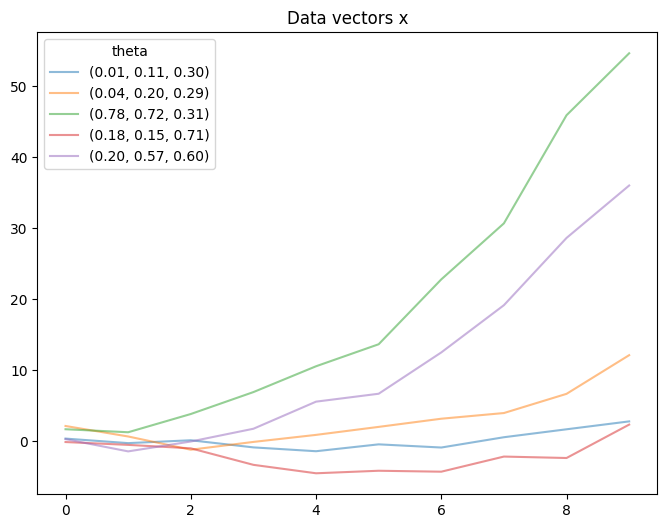

In [7]:
# plot some examples of the data
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5):
    ind = np.random.randint(len(theta))
    ax.plot(x[ind], alpha=0.5, label=f'(%.2f, %.2f, %.2f)' % tuple(theta[ind]))
ax.legend(title='theta')
ax.set_title('Data vectors x')
plt.show()

The following cell is the main configuration setup for the package. We define the prior distribution, the type of inference (NPE, NLE) and the NN model. We can define multiple NN architectures into a list that will be fitted sequentially.

In [8]:
# define a prior
prior = ili.utils.Uniform(low=[0, 0, 0], high=[1, 1, 1], device=device)

# instantiate your neural networks to be used as an ensemble
repeats_maf = 2 # not to have to duplicate code for a large ensemble of identical architectures
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5, repeats = repeats_maf),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [9]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 3.


 Neural network successfully converged after 219 epochs.

INFO:root:Training model 2 / 3.


 Training neural network. Epochs trained: 174

INFO:root:Training model 3 / 3.


 Neural network successfully converged after 158 epochs.

INFO:root:It took 63.83711004257202 seconds to train models.


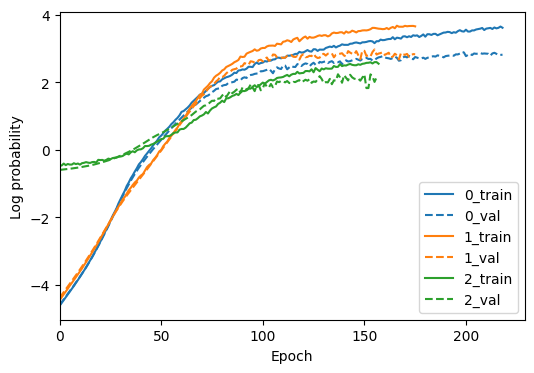

In [10]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

We can now sample the posterior distributions from the ensemble of all networks trained

In [11]:
# choose a random input
seed_in = 49
np.random.seed(seed_in)
ind = np.random.randint(len(theta))

# generate samples from the posterior using accept/reject sampling
seed_samp = 32
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(x[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(x[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

Drawing 352 posterior samples: 408it [00:03, 107.74it/s]                        
Drawing 468 posterior samples: 514it [00:00, 5207.33it/s]             
Drawing 180 posterior samples: 265it [00:01, 185.69it/s]                         


Example of posterior samples for a given input. The true value is indicated with a red cross.

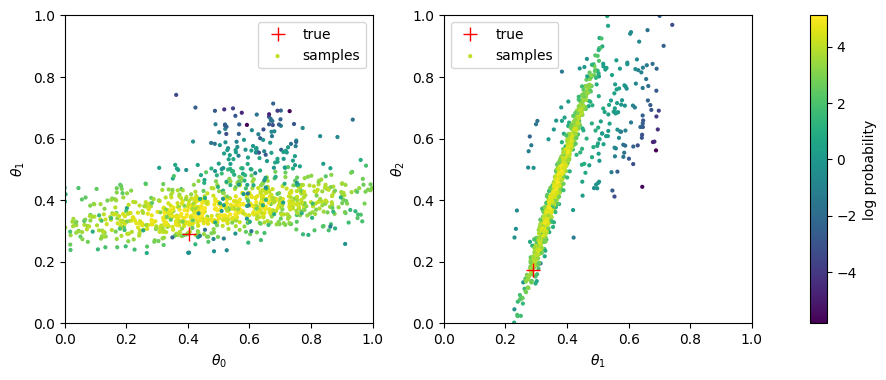

In [12]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

Drawing 381 posterior samples: 428it [00:00, 4123.96it/s]             
Drawing 434 posterior samples: 478it [00:00, 4702.04it/s]             
Drawing 185 posterior samples: 272it [00:00, 4930.83it/s]             


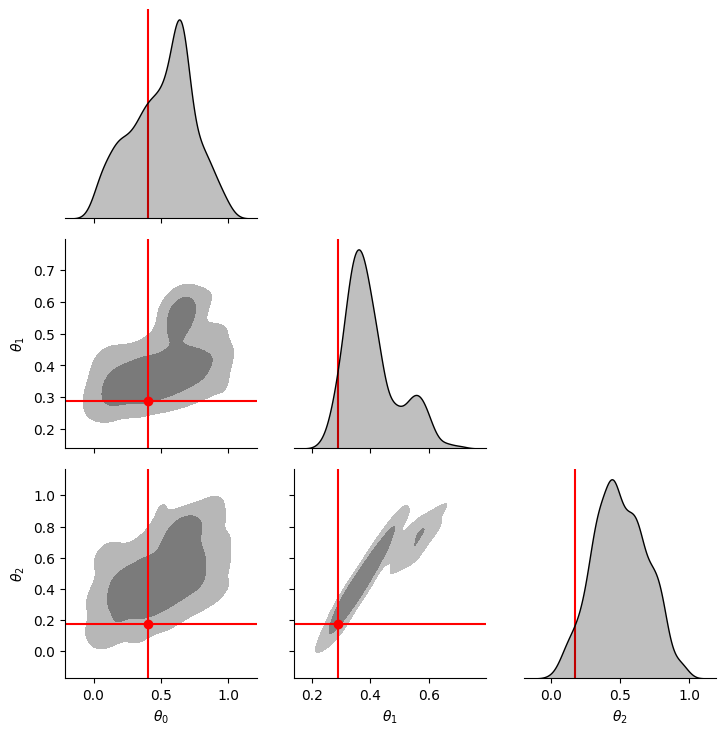

In [13]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind].astype('float32'), theta_fid=theta[ind],
    plot_kws=dict(fill=True)
)

Validation metrics

In [14]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x.astype('float32'), theta=theta
)

  6%|▌         | 12/200 [00:06<01:48,  1.73it/s]


KeyboardInterrupt: 

We can also explore the different NN models independently (instead of the ensemble posterior)

Drawing 1000 posterior samples: 1054it [00:00, 3482.86it/s]                         
Drawing 1000 posterior samples: 1055it [00:00, 4489.49it/s]             


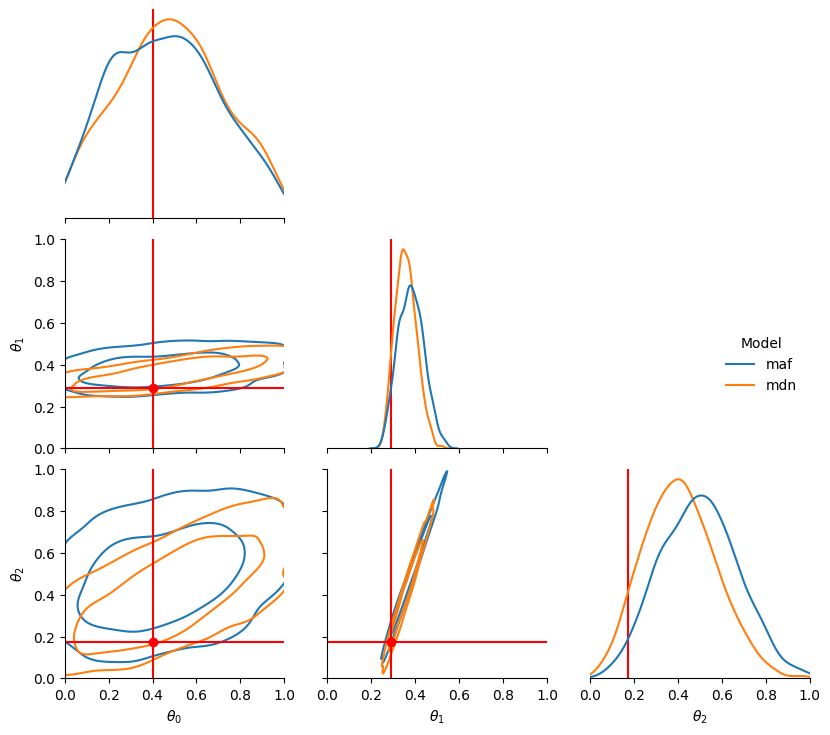

In [17]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=[f'$\\theta_{i}$' for i in range(3)]
)

# plot the posterior for model #1 (MAF)
fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x_obs = x[ind].astype('float32'), theta_fid=theta[ind],
    name='maf',
    lower=np.zeros(3), upper=np.ones(3)
)
# overplot the posterior for model #2 (MDN)
fig = metric(
    posterior=posterior_ensemble.posteriors[1],
    x_obs = x[ind].astype('float32'), theta_fid=theta[ind],
    name='mdn',
    lower=np.zeros(3), upper=np.ones(3),
    grid=fig  # overplot on the same figure
)

100%|██████████| 100/100 [00:00<00:00, 123.53it/s]


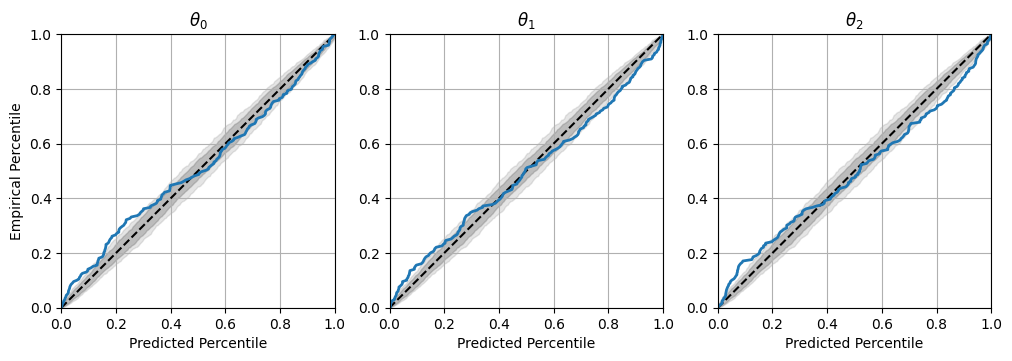

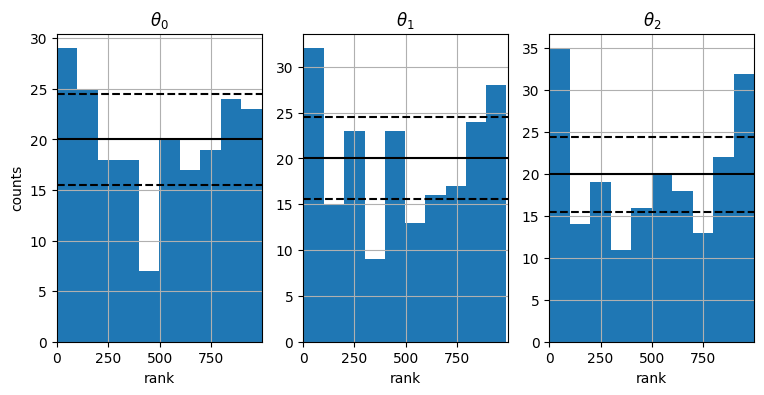

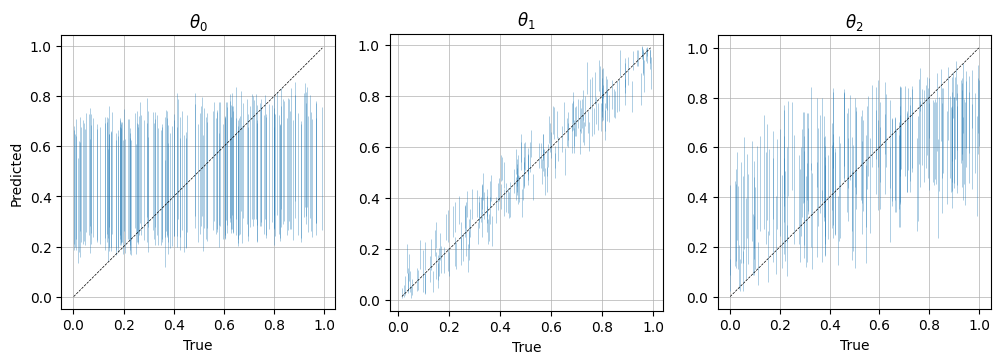

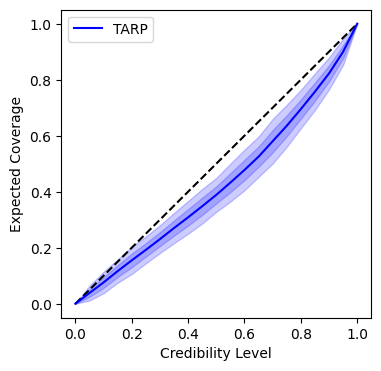

In [19]:
# Drawing samples for each posterior in the ensemble
# First the MAF posterior
metric = PosteriorCoverage(num_samples=1000,
    sample_method='direct', labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"])

fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x=x.astype('float32'), theta=theta
)

# Toy Example with Simulated Data (NLE)

In [ ]:
# create the same synthetic catalog as the previous example
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 4321
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

We now set the type of infernece to NLE

In [ ]:
# define a prior
prior = ili.utils.Uniform(low=[0, 0, 0], high=[1, 1, 1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NLE', model='maf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NLE', model='made', hidden_features=50, num_transforms=5),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-5
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NLE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [ ]:

# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

In [ ]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Because it is NLE, sampling the posterior requires a sampling algorithm such as MCMC or similar

In [ ]:
# choose a random input
seed_ind = 24
np.random.seed(seed_ind)
ind = np.random.randint(len(theta))

# generate samples from the posterior using MCMC
samples = posterior_ensemble.sample(
    (1000,), x[ind],
    method='slice_np_vectorized', num_chains=6
).detach().cpu().numpy()

# calculate the potential (prop. to log_prob) for each sample
log_prob = posterior_ensemble.log_prob(
    samples,
    x[ind]
).detach().cpu().numpy()

In [ ]:
# plot the posterior samples and the true value
f, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='potential', use_gridspec=True, cax=axs[2])

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PosteriorCoverage(
    num_samples=1000, sample_method='vi',
    sample_params={'dist': 'maf', 'n_particles': 32, 'learning_rate': 1e-2},
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"]
)

# Drawing samples from the ensemble posterior
fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)

# Cosmological inference with one galaxy (CAMELS)

In [20]:
# CAMELS (Google Drive) -> save into notebooks/Y2/data/camels
from pathlib import Path

# Ensure the shared DATA_DIR exists (set by the bootstrap). Fallback for safety.
CAMELS_DIR = (DATA_DIR if 'DATA_DIR' in globals() else Path.cwd() / 'data') / 'camels'
CAMELS_DIR.mkdir(parents=True, exist_ok=True)

# Map output filenames to Google Drive file IDs (add more if you have them)
gdrive_files = {
    "X_train.npy": "15WCEscE3lv36jPVOSZdWBwPvA-19b1TS",  # your working id
    "X_test.npy": "1W3cpESM87yMZxFeSz6MaRojVgda9rPSF",
    "omega_m_train.npy" : "1jN75_3OVeJo6wZDpWefHafEMZth5On0W",
    "sigma_8_train.npy" : "1fCgXbrMMpiZ8qttVl74nk1iq6zAMVs2j",
    "omega_m_test.npy" : "1CTSWAv1HRkJhzrUUYyfzxw43ICuI5aFT",
    "sigma_8_test.npy" : "115aL1KarbN3aHRH2ZcnNy5QHyS0gtzk8",


}

saved = {}
for fname, fid in gdrive_files.items():
    dst = CAMELS_DIR / fname
    path = download(fid, dst, unzip=False)  # uses the bootstrap helper
    saved[fname] = path
    print(f"Saved: {path}")


Downloading...
From: https://drive.google.com/uc?id=15WCEscE3lv36jPVOSZdWBwPvA-19b1TS
To: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks/data/camels/X_train.npy
100%|██████████| 41.3M/41.3M [00:17<00:00, 2.40MB/s]


Saved: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks/data/camels/X_train.npy


Downloading...
From: https://drive.google.com/uc?id=1W3cpESM87yMZxFeSz6MaRojVgda9rPSF
To: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks/data/camels/X_test.npy
100%|██████████| 2.42M/2.42M [00:00<00:00, 3.14MB/s]


Saved: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks/data/camels/X_test.npy


Downloading...
From: https://drive.google.com/uc?id=1jN75_3OVeJo6wZDpWefHafEMZth5On0W
To: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks/data/camels/omega_m_train.npy
100%|██████████| 2.43M/2.43M [00:01<00:00, 1.54MB/s]


Saved: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks/data/camels/omega_m_train.npy


Downloading...
From: https://drive.google.com/uc?id=1fCgXbrMMpiZ8qttVl74nk1iq6zAMVs2j
To: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks/data/camels/sigma_8_train.npy
100%|██████████| 2.43M/2.43M [00:01<00:00, 1.61MB/s]


Saved: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks/data/camels/sigma_8_train.npy


Downloading...
From: https://drive.google.com/uc?id=1CTSWAv1HRkJhzrUUYyfzxw43ICuI5aFT
To: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks/data/camels/omega_m_test.npy
100%|██████████| 142k/142k [00:00<00:00, 1.25MB/s]


Saved: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks/data/camels/omega_m_test.npy


Downloading...
From: https://drive.google.com/uc?id=115aL1KarbN3aHRH2ZcnNy5QHyS0gtzk8
To: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks/data/camels/sigma_8_test.npy
100%|██████████| 142k/142k [00:00<00:00, 1.30MB/s]

Saved: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y2/notebooks/data/camels/sigma_8_test.npy


In [21]:
X_train = np.load('./toy/X_train.npy')
omega_m_train = np.load('./toy/omega_m_train.npy')
sigma_8_train = np.load('./toy/sigma_8_train.npy')

X_test = np.load('./toy/X_test.npy')
omega_m_test = np.load('./toy/omega_m_test.npy')
sigma_8_test = np.load('./toy/sigma_8_test.npy')

### Create the DataLoader

If you run in Colab, use only  ~10k examples or less for training. Otherwise it is too slow.

In [22]:
N_EXAMPLES = 10000

theta = np.zeros((len(omega_m_train),2))
theta[:,0]=omega_m_train
theta[:,1]=sigma_8_train
#make a dataloader
loader = NumpyLoader(x=X_train[0:N_EXAMPLES,:], theta=theta[0:N_EXAMPLES,:])

<Figure size 800x600 with 0 Axes>

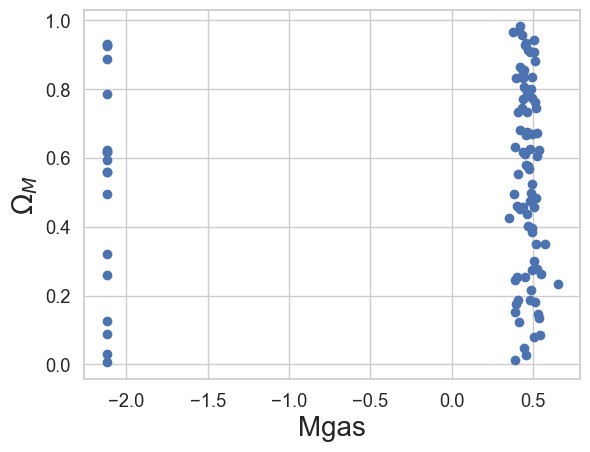

<Figure size 800x600 with 0 Axes>

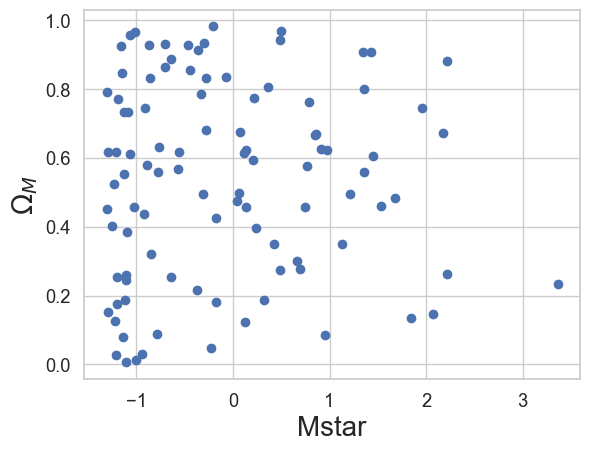

<Figure size 800x600 with 0 Axes>

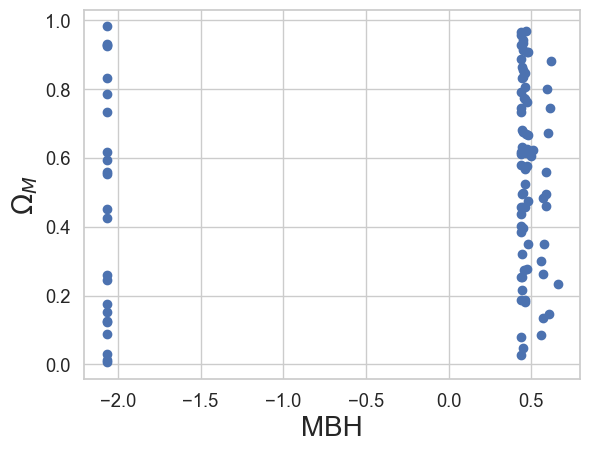

<Figure size 800x600 with 0 Axes>

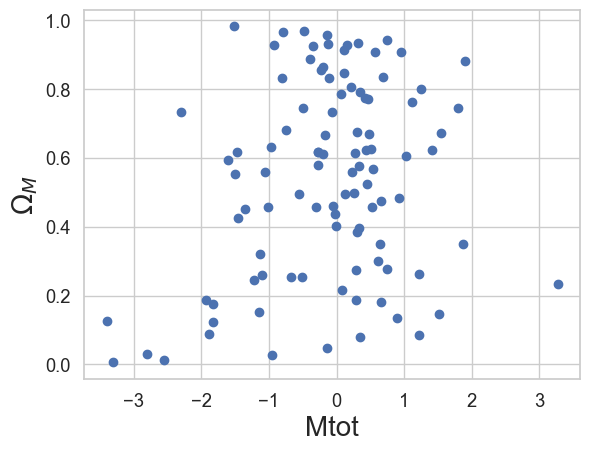

<Figure size 800x600 with 0 Axes>

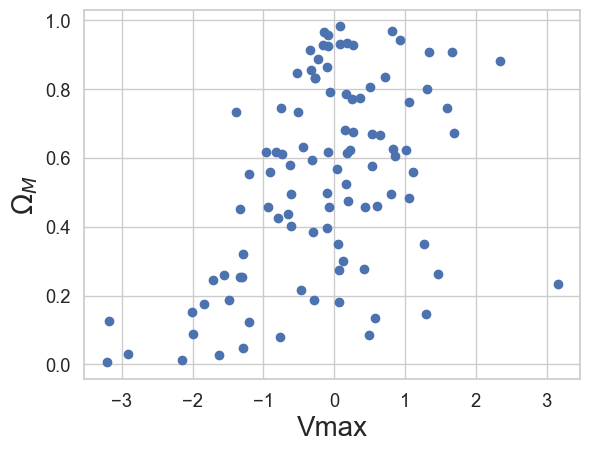

<Figure size 800x600 with 0 Axes>

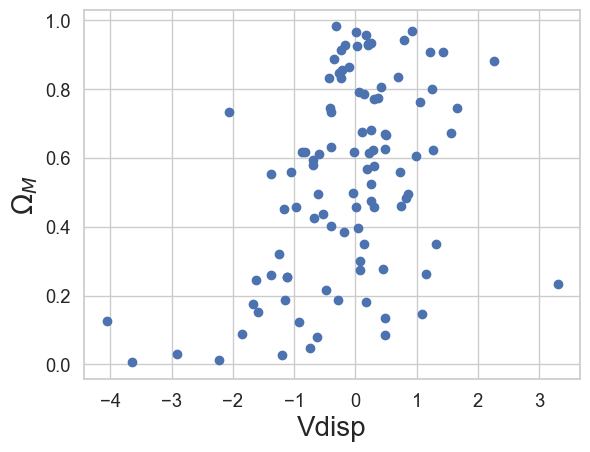

<Figure size 800x600 with 0 Axes>

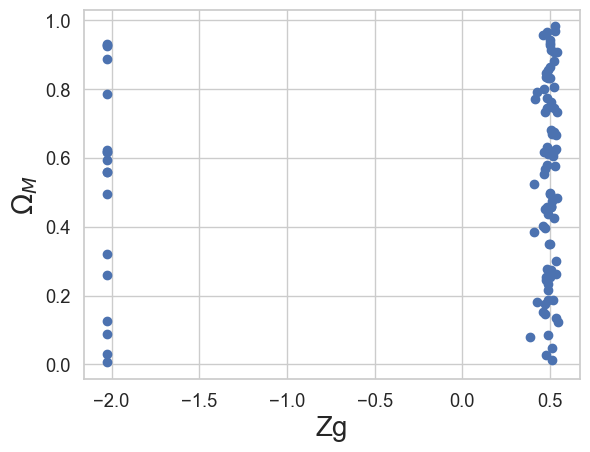

<Figure size 800x600 with 0 Axes>

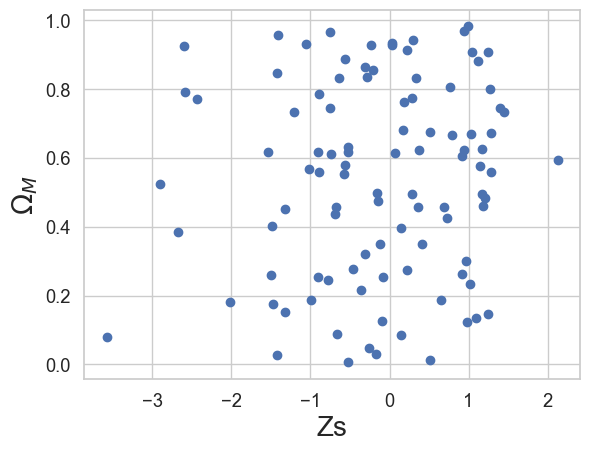

<Figure size 800x600 with 0 Axes>

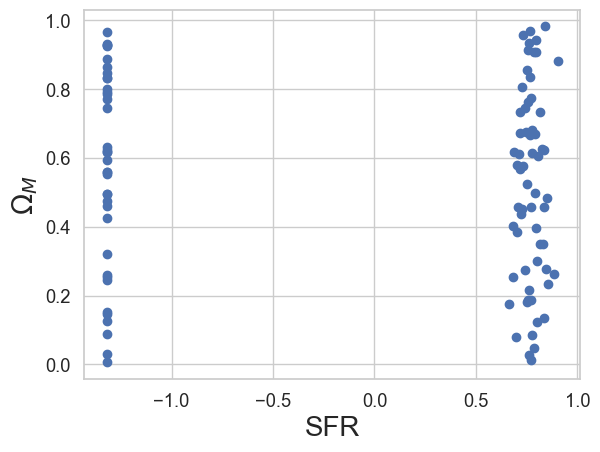

<Figure size 800x600 with 0 Axes>

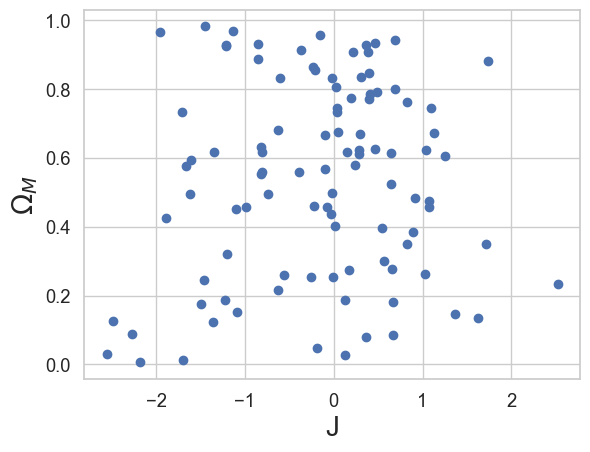

<Figure size 800x600 with 0 Axes>

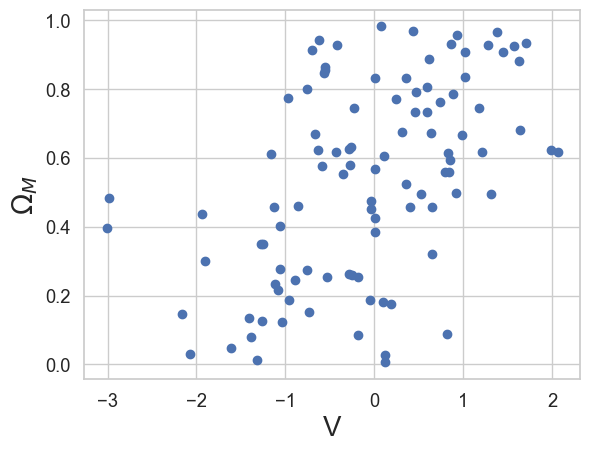

<Figure size 800x600 with 0 Axes>

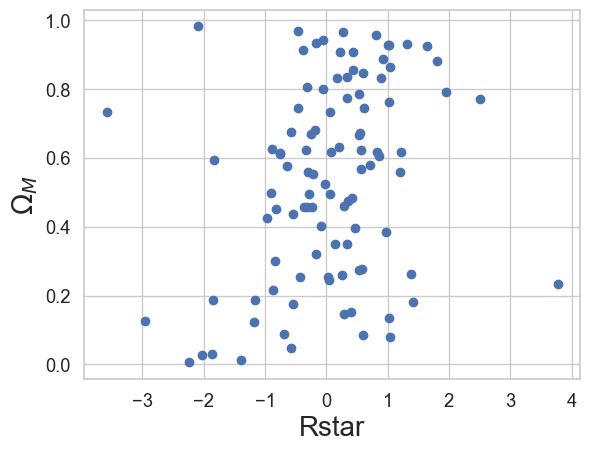

<Figure size 800x600 with 0 Axes>

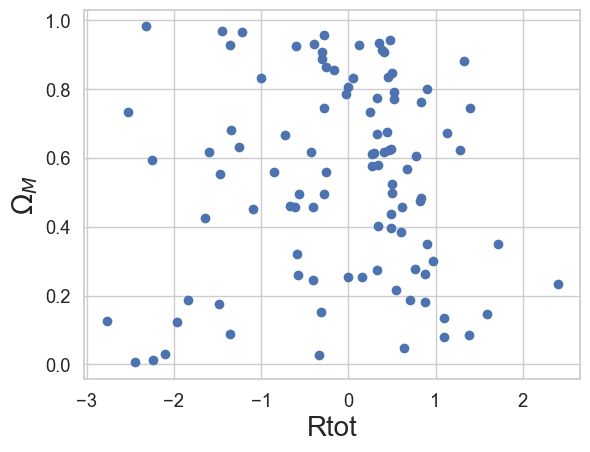

<Figure size 800x600 with 0 Axes>

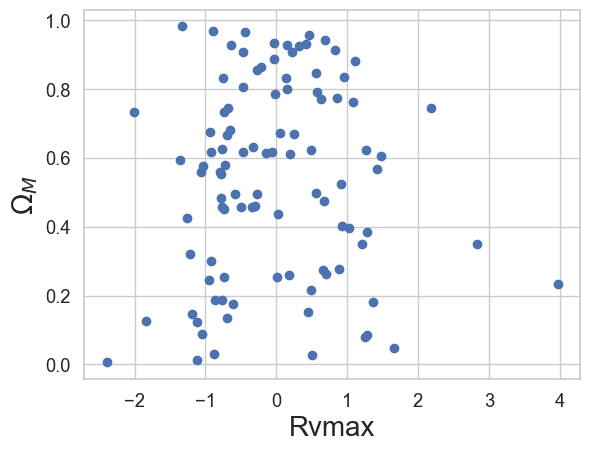

<Figure size 800x600 with 0 Axes>

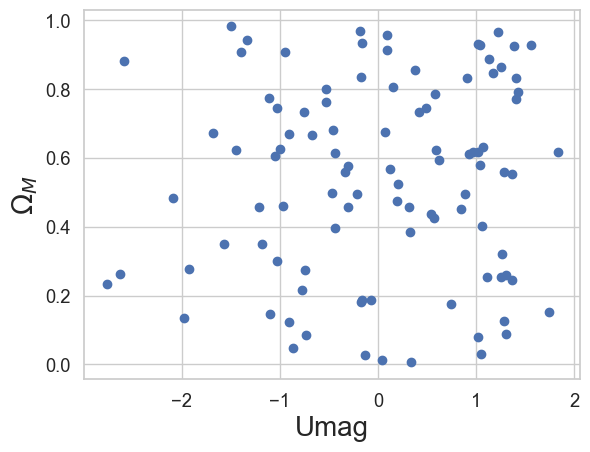

<Figure size 800x600 with 0 Axes>

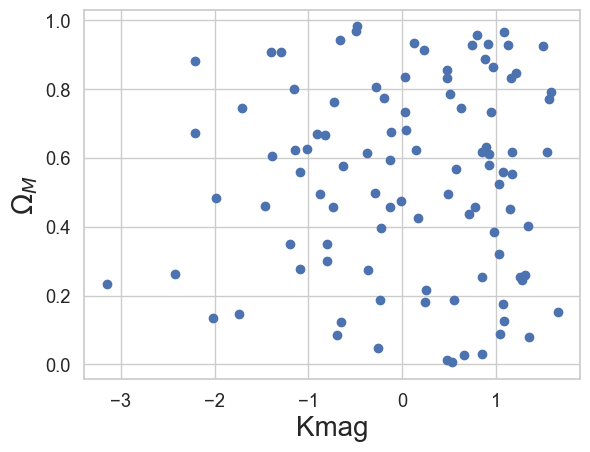

<Figure size 800x600 with 0 Axes>

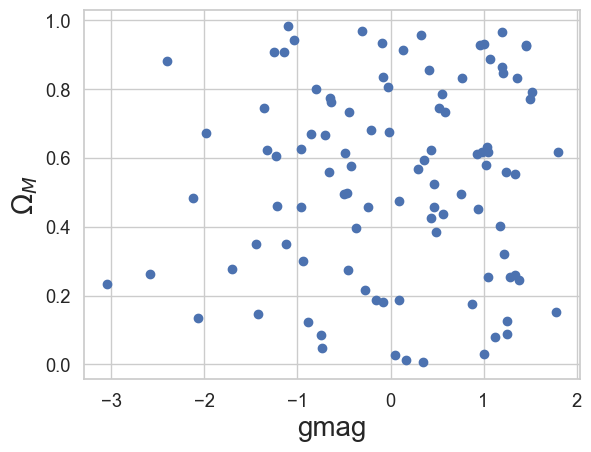

In [23]:
import seaborn as sns
galprop=["Mgas","Mstar","MBH","Mtot","Vmax","Vdisp","Zg","Zs","SFR","J","V","Rstar","Rtot","Rvmax","Umag","Kmag","gmag"]
cosmo=["$\Omega_M$","$\sigma_8$"]

for galprop_ind,lbl in zip(range(len(galprop)),galprop):

    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))
    plt.figure()
    plt.scatter(X_train[0:100,galprop_ind],theta[0:100,0])
    plt.xlabel(lbl,fontsize=20)
    plt.ylabel(cosmo[0],fontsize=20)

In [ ]:
galprop=["Mgas","Mstar","MBH","Mtot","Vmax","Vdisp","Zg","Zs","SFR","J","V","Rstar","Rtot","Rvmax","Umag","Kmag","gmag"]
cosmo=["$\Omega_M$","$\sigma_8$"]

for galprop_ind,lbl in zip(range(len(galprop)),galprop):

    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))
    plt.figure()
    plt.scatter(X_train[0:100,galprop_ind],theta[0:100,1])
    plt.xlabel(lbl,fontsize=20)
    plt.ylabel(cosmo[1],fontsize=20)

In [ ]:
# define a prior
prior = ili.utils.Uniform(low=[0, 0], high=[1, 1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
    #ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [ ]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [ ]:
# choose a random input
seed_in = 49
np.random.seed(seed_in)
ind = np.random.randint(len(theta))

# generate samples from the posterior using accept/reject sampling
seed_samp = 32
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(X_train[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(X_train[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['$\Omega_M$','$\sigma_8$']
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = X_train[ind], theta_fid=theta[ind],
    plot_kws=dict(fill=True)
)

# Inference with the CAMELS MultiField Dataset (Images of Baryonic Fields)

In [ ]:
# Download CAMELS 2D maps and latin hypercube parameters (~3.2 GB)
import os
os.makedirs('./toy', exist_ok=True)
!curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/Maps_T_IllustrisTNG_LH_z=0.00.npy -o ./toy/Maps_T_IllustrisTNG_LH_z=0.00.npy
!curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/params_LH_IllustrisTNG.txt -o ./toy/params_LH_IllustrisTNG.txt

In [24]:
# CAMELS (HTTP) -> maps & LH params via helper
from pathlib import Path

CAMELS_DIR = (DATA_DIR if 'DATA_DIR' in globals() else Path.cwd() / 'data') / 'camels'
CAMELS_DIR.mkdir(parents=True, exist_ok=True)

# If your notebook already defined these above, this will use them as-is.
# Otherwise, uncomment and paste your full URLs:
url_maps   = "https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/Maps_T_IllustrisTNG_LH_z=0.00.npy"
url_params = "https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/IllustrisTNG/params_LH_IllustrisTNG.txt -o ./toy/params_LH_IllustrisTNG.txt"

if "url_maps" not in globals() or "url_params" not in globals():
    raise NameError("Please define `url_maps` and `url_params` above with your full, working URLs.")

maps_path   = download(url_maps,   CAMELS_DIR, unzip=False)
params_path = download(url_params, CAMELS_DIR, unzip=False)

print("Maps   file:", maps_path)
print("Params file:", params_path)


KeyboardInterrupt: 

In [ ]:
# load data
x = np.log10(np.load('/content/toy/Maps_T_IllustrisTNG_LH_z=0.00.npy', allow_pickle=True))
theta = np.loadtxt('/content/toy/params_LH_IllustrisTNG.txt')
theta = np.repeat(theta, 15, axis=0)

# subsample (for speed)
x = x[::2]
theta = theta[::2]

# conform images to pytorch expected shape
x = x[:,None,...]

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

# determine prior bounds
prior_min = theta.min(axis=0)
prior_max = theta.max(axis=0)

In [ ]:
labels = [r'$\Omega_m$', r'$\sigma_8$', r'$A_{SN1}$',
          r'$A_{AGN1}$', r'$A_{SN2}$', r'$A_{AGN2}$']

# plot a few examples of the data
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    ind = np.random.randint(len(x))
    im = axs[i].imshow(x[ind,0], cmap='RdBu_r')

    title = [f'{labels[j]}={theta[ind,j]:.2f}' for j in range(6)]
    title.insert(3, '\n')
    axs[i].set_title(' '.join(title))
    axs[i].axis('off')

In [ ]:
# let's build a convolutional embedding network for processing images

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=8, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [ ]:
# define a prior
prior = ili.utils.Uniform(low=prior_min, high=prior_max, device=device)

# instantiate a CNN embedding network
embedding_net = ConvNet()

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5,
                           embedding_net=embedding_net),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6,
                           embedding_net=embedding_net)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-5,
    'stop_after_epochs': 50
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [ ]:
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [ ]:
# choose a random input
ind = np.random.randint(len(theta))
x_test = torch.Tensor(x[ind]).to(device)

# generate samples from the posterior using accept/reject sampling
samples = posterior_ensemble.sample((1000,), x_test)
# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, x_test)

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

In [ ]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_xlim(prior_min[i], prior_max[i])
    axs[i].set_ylim(prior_min[i+1], prior_max[i+1])
    axs[i].set_xlabel(labels[i])
    axs[i].set_ylabel(labels[i+1])
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=labels, out_dir=None
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind],
)